In [2]:
import pandas as pd
from pandas.core.common import SettingWithCopyWarning

import warnings
warnings.filterwarnings("ignore")
import json

from datetime import datetime
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import re

import requests

In [3]:
def plot_roc_curve(true_y, y_prob):

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

В этом блокноте будут лежать эксперименты с моделями и данными. Для начала, посмотрим, сможем ли улучшить качество, сгенерировав больше фичей.

In [4]:
data_rare = pd.read_csv('data_rare.csv', index_col=[0])

In [5]:
data_rare.loc[~data_rare['handshake'].isna(), 'is_handshake'] = 1
data_rare.loc[data_rare['is_handshake'].isna(), 'is_handshake'] = 0

In [ ]:
fingerprint = []
alert_message = []
certificate = []
is_selfsigned = []

for i in range(0, len(data_rare)):
    fingerprint.append(len(re.findall('fingerprint', data_rare['handshake'].fillna('0')[i], flags=0)))
    alert_message.append(len(re.findall('alert_message', data_rare['packets'].fillna('0')[i], flags=0)))
    certificate.append(len(re.findall('certificate', data_rare['handshake'].fillna('0')[i], flags=0)))
    is_selfsigned.append(len(re.findall("'is_selfsigned': True", data_rare['handshake'].fillna('0')[i], flags=0)))

data_rare['fingerprint'] = fingerprint
data_rare['alert_message'] = alert_message
data_rare['certificate'] = certificate
data_rare['is_selfsigned'] = is_selfsigned

In [ ]:
df = data_rare.drop(['index', 'packets', 'handshake', 'timestamps'], axis = 1)
df['country'] = pd.read_csv('data.csv')['country']

In [ ]:
sns.heatmap(df[['addr', 'port', 'proto',
               'num_timestamps', 'mean_timestamps', 'median_timestamps', 'anomaly',
               'is_handshake', 'fingerprint', 'alert_message', 'certificate', 'is_selfsigned']].drop_duplicates().corr(), 
            cmap="Blues", annot=True);

# Подготовим данные:

1. Удалим скоррелированные колонки
2. Сделаем resemple для трейна
3. Скалируем

In [ ]:
df = df.drop(['mean_timestamps', 'certificate', 'fingerprint'], axis = 1).drop_duplicates()

In [ ]:
X = df[['addr', 'proto', 'num_timestamps', 
    'median_timestamps', 'anomaly', 'country', 'is_handshake',
       'alert_message', 'is_selfsigned']].drop_duplicates()
X = X.fillna(0)

X = X[X['addr'] != '10.4.19.138']

In [ ]:
X.anomaly.nunique()

In [ ]:
X.shape

In [ ]:
X['addr_1'] = pd.DataFrame(list(X['addr'].str.split('.').values), columns = ['addr_1',
                                                        'addr_2',
                                                        'addr_3', 
                                                        'addr_4'])['addr_1']

X['addr_2'] = pd.DataFrame(list(X['addr'].str.split('.').values), columns = ['addr_1',
                                                        'addr_2',
                                                        'addr_3', 
                                                        'addr_4'])['addr_2']

In [ ]:
X.anomaly.nunique()

In [ ]:
X.shape

In [ ]:
X_new = X.drop(['proto', 'country', 'addr_1', 'addr_2'], 
                     axis=1).merge(pd.get_dummies(X[['proto', 'country', 'addr_1', 'addr_2']], drop_first = True),
                                                    left_index = True, right_index=True)

In [ ]:
X_new.anomaly.nunique()

In [ ]:
y = X_new['anomaly']
X = X_new.drop(['anomaly', 'addr'], axis = 1)

from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = 42, test_size = 0.3)

In [ ]:
!pip install imblearn

from imblearn.over_sampling import SMOTE
sm = SMOTE(#sampling_strategy = 0.9,
            random_state=0,
            k_neighbors=4)

X_train_res, y_train_res = sm.fit_resample(Xtrain, ytrain) 

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train_res)

In [ ]:
X_train_res = scaler.transform(X_train_res)

In [ ]:
Xtest = scaler.transform(Xtest)

In [ ]:
from sklearn.metrics import make_scorer

score = make_scorer(fbeta_score, beta=1.5)

In [ ]:
def fbeta(beta = 1, )

В первую очередь возьмем катбуст из ноутбука с EDA и переберем параметры для улучшения качества.

# Итерация 1

In [256]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

params = {'depth': [None, 1, 5, 10],
          'learning_rate' : [None, 0.05, 0.1, 0.5],
          'iterations'    : [None, 100, 200]
         }

ctb = CatBoostClassifier(random_state=42, verbose=False)

ctb_model = GridSearchCV(ctb, params, scoring=score, return_train_score=True, verbose=2.1)
ctb_model.fit(X_train_res, y_train_res)
print(ctb_model.best_params_)
print(ctb_model.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END depth=None, iterations=None, learning_rate=None;, score=(train=0.980, test=0.973) total time=  16.1s
[CV 2/5] END depth=None, iterations=None, learning_rate=None;, score=(train=0.979, test=0.977) total time=  15.9s
[CV 3/5] END depth=None, iterations=None, learning_rate=None;, score=(train=0.980, test=0.976) total time=  15.5s
[CV 4/5] END depth=None, iterations=None, learning_rate=None;, score=(train=0.980, test=0.974) total time=  15.4s
[CV 5/5] END depth=None, iterations=None, learning_rate=None;, score=(train=0.980, test=0.979) total time=  15.3s
[CV 1/5] END depth=None, iterations=None, learning_rate=0.05;, score=(train=0.982, test=0.975) total time=  15.8s
[CV 2/5] END depth=None, iterations=None, learning_rate=0.05;, score=(train=0.981, test=0.981) total time=  16.1s
[CV 3/5] END depth=None, iterations=None, learning_rate=0.05;, score=(train=0.982, test=0.979) total time=  15.2s
[CV 4/5] END depth=None, i

[CV 4/5] END depth=1, iterations=None, learning_rate=0.1;, score=(train=0.967, test=0.960) total time=  11.0s
[CV 5/5] END depth=1, iterations=None, learning_rate=0.1;, score=(train=0.965, test=0.962) total time=  11.2s
[CV 1/5] END depth=1, iterations=None, learning_rate=0.5;, score=(train=0.983, test=0.977) total time=  10.8s
[CV 2/5] END depth=1, iterations=None, learning_rate=0.5;, score=(train=0.982, test=0.983) total time=  11.7s
[CV 3/5] END depth=1, iterations=None, learning_rate=0.5;, score=(train=0.982, test=0.979) total time=  11.0s
[CV 4/5] END depth=1, iterations=None, learning_rate=0.5;, score=(train=0.983, test=0.977) total time=  11.0s
[CV 5/5] END depth=1, iterations=None, learning_rate=0.5;, score=(train=0.981, test=0.983) total time=  10.9s
[CV 1/5] END depth=1, iterations=100, learning_rate=None;, score=(train=0.933, test=0.932) total time=   3.4s
[CV 2/5] END depth=1, iterations=100, learning_rate=None;, score=(train=0.931, test=0.925) total time=   3.4s
[CV 3/5] E

[CV 4/5] END depth=5, iterations=100, learning_rate=0.05;, score=(train=0.903, test=0.894) total time=   3.9s
[CV 5/5] END depth=5, iterations=100, learning_rate=0.05;, score=(train=0.906, test=0.908) total time=   3.7s
[CV 1/5] END depth=5, iterations=100, learning_rate=0.1;, score=(train=0.945, test=0.940) total time=   3.7s
[CV 2/5] END depth=5, iterations=100, learning_rate=0.1;, score=(train=0.946, test=0.939) total time=   3.8s
[CV 3/5] END depth=5, iterations=100, learning_rate=0.1;, score=(train=0.946, test=0.943) total time=   3.8s
[CV 4/5] END depth=5, iterations=100, learning_rate=0.1;, score=(train=0.945, test=0.939) total time=   3.8s
[CV 5/5] END depth=5, iterations=100, learning_rate=0.1;, score=(train=0.944, test=0.942) total time=   4.1s
[CV 1/5] END depth=5, iterations=100, learning_rate=0.5;, score=(train=0.982, test=0.976) total time=   4.4s
[CV 2/5] END depth=5, iterations=100, learning_rate=0.5;, score=(train=0.982, test=0.979) total time=   3.8s
[CV 3/5] END dept

[CV 4/5] END depth=10, iterations=200, learning_rate=None;, score=(train=0.983, test=0.977) total time=  10.8s
[CV 5/5] END depth=10, iterations=200, learning_rate=None;, score=(train=0.982, test=0.981) total time=  10.5s
[CV 1/5] END depth=10, iterations=200, learning_rate=0.05;, score=(train=0.963, test=0.956) total time=  10.4s
[CV 2/5] END depth=10, iterations=200, learning_rate=0.05;, score=(train=0.964, test=0.956) total time=  10.4s
[CV 3/5] END depth=10, iterations=200, learning_rate=0.05;, score=(train=0.963, test=0.957) total time=  10.3s
[CV 4/5] END depth=10, iterations=200, learning_rate=0.05;, score=(train=0.964, test=0.958) total time=  10.5s
[CV 5/5] END depth=10, iterations=200, learning_rate=0.05;, score=(train=0.963, test=0.961) total time=  10.3s
[CV 1/5] END depth=10, iterations=200, learning_rate=0.1;, score=(train=0.980, test=0.970) total time=  10.4s
[CV 2/5] END depth=10, iterations=200, learning_rate=0.1;, score=(train=0.979, test=0.976) total time=  10.4s
[CV

KeyError: 'depth'

In [257]:
print(ctb_model.best_params_)
print(ctb_model.best_score_)

{'depth': None, 'iterations': None, 'learning_rate': 0.5}
0.9830342282023323


In [258]:
clf = CatBoostClassifier(random_state=42, verbose=False,
                        depth= None, iterations= 200, learning_rate= 0.5)

In [259]:
model_ctb = clf.fit(X_train_res, y_train_res)

In [260]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

print (f"roc_auc_score на трейне: {round(roc_auc_score(y_train_res, model_ctb.predict(X_train_res)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_ctb.predict(Xtest)), 2)}")

roc_auc_score на трейне: 0.99
roc_auc_score на тесте: 0.97


In [261]:
print (f"f1_score на трейне: {round(fbeta_score(y_train_res, model_ctb.predict(X_train_res), beta=0.2), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_ctb.predict(Xtest), beta=0.2), 2)}")

f1_score на трейне: 0.98
f1_score на тесте: 0.58


In [226]:
# сильно переобучилась под трейн

model AUC score: 0.968963506312601


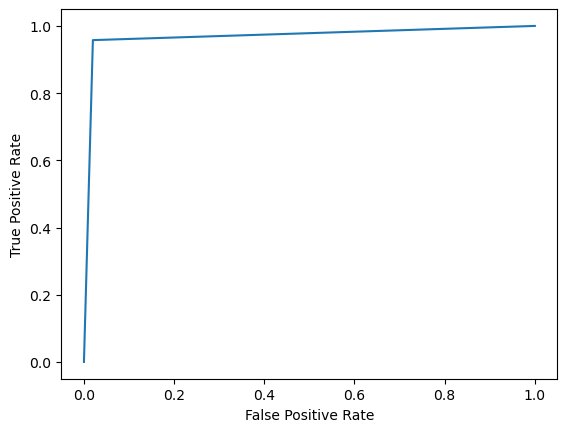

In [262]:
plot_roc_curve(ytest, model_ctb.predict(Xtest))
print(f'model AUC score: {roc_auc_score(ytest, model_ctb.predict(Xtest))}')

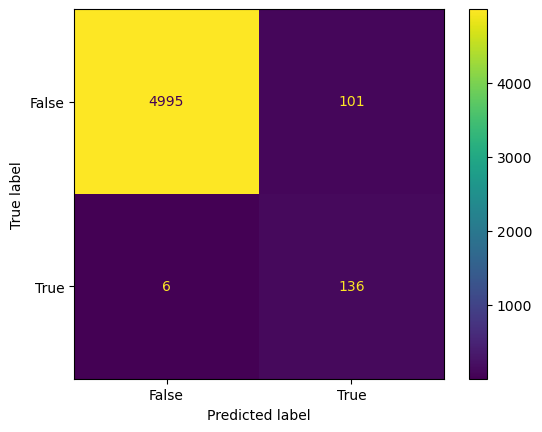

In [263]:
confusion_matrix = confusion_matrix(ytest, model_ctb.predict(Xtest))

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()
# много ошибается на определении аноималии

In [265]:
feat = pd.DataFrame(model_ctb.feature_importances_,
            columns=['coefs'])
feat['features'] = list(X_new.drop(['addr', 'anomaly'], axis=1).columns)

In [266]:
feat = feat.sort_values('coefs', ascending=False).head(20)

<function matplotlib.pyplot.show(close=None, block=None)>

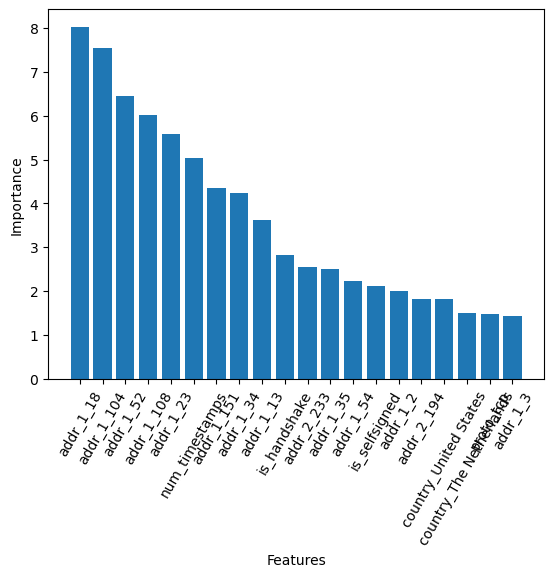

In [267]:
plt.bar(feat['features'], feat['coefs'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=75)
plt.show

In [21]:
import pickle
pickle.dump(model, open('ctb_model.pkl', 'wb'))

In [22]:
import joblib

joblib.dump(scaler, 'std_scaler.bin', compress=True)

['std_scaler.bin']

# Итерация 2

max_depth поставить меньше

In [268]:
from sklearn.ensemble import RandomForestClassifier

params = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
    }
rfc = RandomForestClassifier(random_state=42)

rfc_model = GridSearchCV(rfc, params, scoring=score)
rfc_model.fit(X_train_res, y_train_res)
print(rfc_model.best_params_)
print(rfc_model.best_score_)

{'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 500}
0.8740421405893384


In [269]:
clf = RandomForestClassifier(random_state=42, criterion = 'gini',
                            max_depth= 8, max_features = 'log2', n_estimators = 500)

In [270]:
model_rfc = clf.fit(X_train_res, y_train_res)

In [271]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_train_res, model_rfc.predict(X_train_res)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_rfc.predict(Xtest)), 2)}")

roc_auc_score на трейне: 0.93
roc_auc_score на тесте: 0.92


In [272]:
print (f"f1_score на трейне: {round(fbeta_score(y_train_res, model_rfc.predict(X_train_res), beta=0.2), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_rfc.predict(Xtest), beta=0.2), 2)}")

f1_score на трейне: 0.88
f1_score на тесте: 0.16


In [191]:
# получше катбуста, но также переобучилась

# Итерация 3

Посмотри, сколько вообще всего аномалий в тесте

In [273]:
from sklearn.linear_model import LogisticRegression

params = {"penalty":["none","l2","l1"]}

lr = LogisticRegression(random_state=42)

lr_model = GridSearchCV(lr, params, scoring=score)
lr_model.fit(X_train_res, y_train_res)
print(lr_model.best_params_)
print(lr_model.best_score_)

{'penalty': 'l2'}
0.9821773052010692


In [274]:
clf = LogisticRegression(random_state=42, penalty= 'l2')
model_lr = clf.fit(X_train_res, y_train_res)

In [275]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_train_res, model_lr.predict(X_train_res)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_lr.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_train_res, model_lr.predict(X_train_res), beta=0.2), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_lr.predict(Xtest), beta=0.2), 2)}")

roc_auc_score на трейне: 0.99
roc_auc_score на тесте: 0.98
f1_score на трейне: 0.98
f1_score на тесте: 0.61


In [296]:
# здесь куда лучше результат

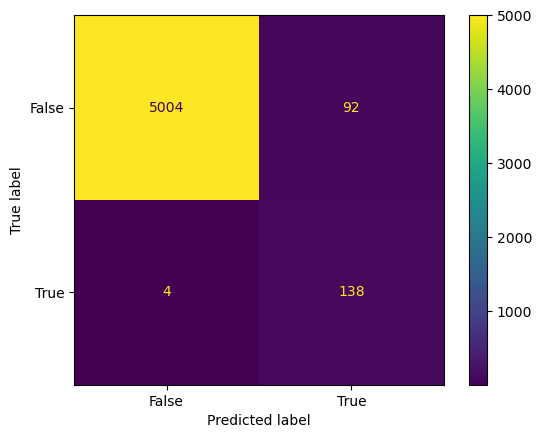

In [295]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay


confusion_matrix = confusion_matrix(ytest, model_lr.predict(Xtest))

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

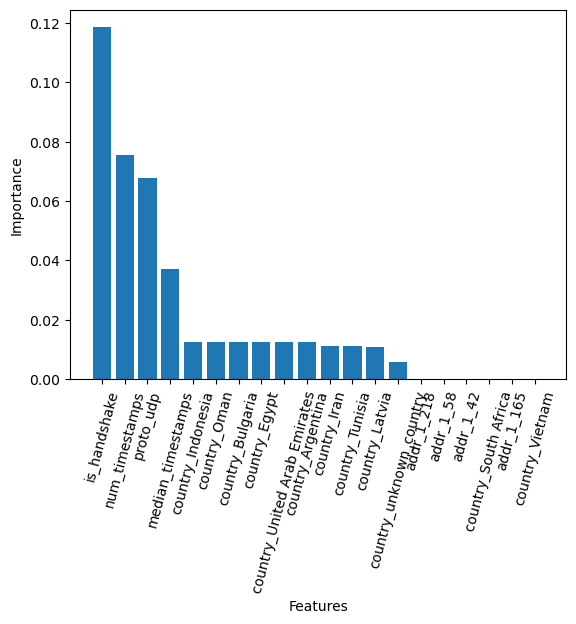

In [301]:
feat = pd.DataFrame(model_lr.coef_[0],
            columns=['coefs'])
feat['features'] = list(X_new.drop(['addr', 'anomaly'], axis=1).columns)
feat = feat.sort_values('coefs', ascending=False).head(20)

plt.bar(feat['features'], feat['coefs'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=75)
plt.show

In [309]:
C = pd.DataFrame(list(ytest), columns=['real'])
C['preds'] = model_lr.predict(Xtest)

In [314]:
len(C[(C['real']==1) & (C['preds']==0)]) / len(C[(C['real']==1)])
# 3 процента выбросов не задетектировали

0.028169014084507043

In [315]:
len(C[(C['real']==0) & (C['preds']==1)]) / len(C[(C['real']==0)])
# и два процента нормальных соединений

0.01805337519623234

In [1]:
len(C[(C['real']==0) & (C['preds']==1)]) + len(C[(C['real']==1) & (C['preds']==0)])

NameError: name 'C' is not defined

# Итерация 4

Возможно, нормальная модель, но надо наоборот развернуть значения
contamination - процент аномалий

In [276]:
from pyod.models.inne import INNE

params = {'n_estimators': [50,100,200,500]}

inn = INNE(random_state=42)

inn_model = GridSearchCV(inn, params, scoring=score)
inn_model.fit(X_train_res, y_train_res)
print(inn_model.best_params_)
print(inn_model.best_score_)

{'contamination': 0.5, 'n_estimators': 200}
0.18761915864176387


In [277]:
clf = INNE(random_state=42, contamination= 0.5, n_estimators = 200)
model_inn = clf.fit(X_train_res, y_train_res)

In [278]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_train_res, model_inn.predict(X_train_res)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_inn.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_train_res, model_inn.predict(X_train_res), beta=0.2), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_inn.predict(Xtest), beta=0.2), 2)}")

roc_auc_score на трейне: 0.08
roc_auc_score на тесте: 0.19
f1_score на трейне: 0.08
f1_score на тесте: 0.01


In [55]:
# здесь совсем слабо

# Итог, 

лучше всего себя показал катбуст. Его и возьмем за основу, будем улучшать.

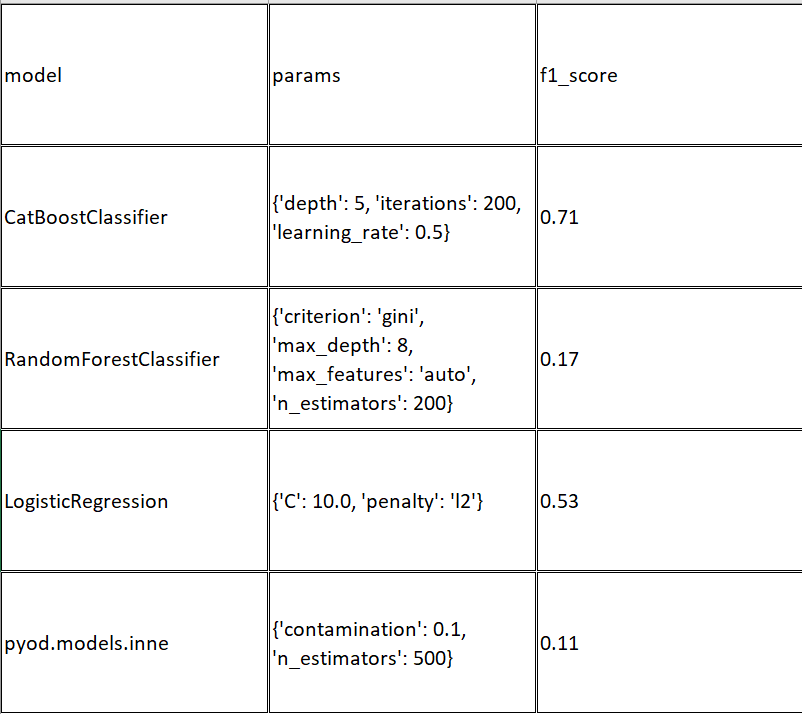

In [279]:
from pyod.models.cblof import CBLOF

params = {'n_clusters': [5,10,50,100],
          'contamination' : [0.01,0.1,0.5]
         }
cblof = CBLOF(random_state=42)

cblof_model = GridSearchCV(cblof, params, scoring=score)
cblof_model.fit(X_train_res, y_train_res)
print(cblof_model.best_params_)
print(cblof_model.best_score_)

{'contamination': 0.5, 'n_clusters': 100}
0.376702289402906


In [280]:
clf = CBLOF(random_state=42, contamination= 0.5, n_clusters = 100)
model_cblof = clf.fit(X_train_res, y_train_res)

In [281]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_train_res, model_cblof.predict(X_train_res)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_cblof.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_train_res, model_cblof.predict(X_train_res), beta=0.2), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_cblof.predict(Xtest), beta=0.2), 2)}")

roc_auc_score на трейне: 0.22
roc_auc_score на тесте: 0.31
f1_score на трейне: 0.22
f1_score на тесте: 0.01


In [282]:
from pyod.models.dif import DIF

params = {'batch_size': [8,256,1000],
          'contamination' : [0.01,0.1,0.5]
         }
dif = DIF(random_state=42)

dif_model = GridSearchCV(dif, params, scoring=score)
dif_model.fit(X_train_res, y_train_res)
print(dif_model.best_params_)
print(dif_model.best_score_)

{'batch_size': 1000, 'contamination': 0.5}
0.3908868224625726


In [285]:
clf = DIF(random_state=42, contamination= 0.5, batch_size = 1000)
model_dif = clf.fit(X_train_res, y_train_res)

In [286]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_train_res, model_dif.predict(X_train_res)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_dif.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_train_res, model_dif.predict(X_train_res), beta=0.2), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_dif.predict(Xtest), beta=0.2), 2)}")

roc_auc_score на трейне: 0.2
roc_auc_score на тесте: 0.37
f1_score на трейне: 0.05
f1_score на тесте: 0.01


In [287]:
from pyod.models.ocsvm import OCSVM

params = {'kernel': ['poly', 'rbf', 'sigmoid'],
          'nu' : [0.01,0.1,0.5]
         }
ocsvm = OCSVM()

ocsvm_model = GridSearchCV(ocsvm, params, scoring=score)
ocsvm_model.fit(X_train_res, y_train_res)
print(ocsvm_model.best_params_)
print(ocsvm_model.best_score_)

{'kernel': 'poly', 'nu': 0.5}
0.5923205442823843


In [289]:
clf = OCSVM(kernel= 'poly', nu = 0.5)
model_ocsvm = clf.fit(X_train_res, y_train_res)

In [290]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_train_res, model_ocsvm.predict(X_train_res)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_ocsvm.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_train_res, model_ocsvm.predict(X_train_res), beta=0.2), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_ocsvm.predict(Xtest), beta=0.2), 2)}")

roc_auc_score на трейне: 0.6
roc_auc_score на тесте: 0.58
f1_score на трейне: 0.85
f1_score на тесте: 0.47


In [328]:
from sklearn.ensemble import GradientBoostingClassifier

params = {'max_depth': [3, 10, 50],
          'learning_rate' : [0.01,0.1,0.5],
          'n_estimators': [20, 100, 200]
         }
gbc = GradientBoostingClassifier(random_state=42)

gbc_model = GridSearchCV(gbc, params, scoring=score, verbose=2.1)
gbc_model.fit(X_train_res, y_train_res)
print(gbc_model.best_params_)
print(gbc_model.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=20;, score=0.632 total time=   6.9s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=20;, score=0.636 total time=   6.6s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=20;, score=0.633 total time=   6.7s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=20;, score=0.624 total time=   6.6s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=20;, score=0.634 total time=   6.5s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.745 total time=  32.2s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.730 total time=  32.9s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.741 total time=  33.3s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.729 total time=  33.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.732 to

[CV 1/5] END learning_rate=0.1, max_depth=50, n_estimators=200;, score=0.972 total time=10.5min
[CV 2/5] END learning_rate=0.1, max_depth=50, n_estimators=200;, score=0.967 total time=10.7min
[CV 3/5] END learning_rate=0.1, max_depth=50, n_estimators=200;, score=0.957 total time=10.6min
[CV 4/5] END learning_rate=0.1, max_depth=50, n_estimators=200;, score=0.959 total time=11.0min
[CV 5/5] END learning_rate=0.1, max_depth=50, n_estimators=200;, score=0.970 total time=11.5min
[CV 1/5] END learning_rate=0.5, max_depth=3, n_estimators=20;, score=0.863 total time=   5.4s
[CV 2/5] END learning_rate=0.5, max_depth=3, n_estimators=20;, score=0.861 total time=   5.5s
[CV 3/5] END learning_rate=0.5, max_depth=3, n_estimators=20;, score=0.871 total time=   5.6s
[CV 4/5] END learning_rate=0.5, max_depth=3, n_estimators=20;, score=0.861 total time=   5.5s
[CV 5/5] END learning_rate=0.5, max_depth=3, n_estimators=20;, score=0.862 total time=   5.5s
[CV 1/5] END learning_rate=0.5, max_depth=3, n_est

In [329]:
clf = GradientBoostingClassifier(random_state=42, max_depth = 10, 
                                learning_rate = 0.5, n_estimators = 200)
model_gbc = clf.fit(X_train_res, y_train_res)

In [330]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_train_res, model_gbc.predict(X_train_res)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_gbc.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_train_res, model_gbc.predict(X_train_res), beta=0.2), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_gbc.predict(Xtest), beta=0.2), 2)}")

roc_auc_score на трейне: 1.0
roc_auc_score на тесте: 0.92
f1_score на трейне: 0.99
f1_score на тесте: 0.6


In [334]:
C = pd.DataFrame(list(ytest), columns=['real'])
C['preds'] = model_gbc.predict(Xtest)

In [335]:
len(C[(C['real']==1) & (C['preds']==0)]) / len(C[(C['real']==1)])
# 14 процентов выбросов не задетектировали

0.14084507042253522

In [336]:
len(C[(C['real']==0) & (C['preds']==1)]) / len(C[(C['real']==0)])
# и два процента нормальных соединений

0.016287284144427

Итого, лучше всего себя проявила логистическая регрессия, попробуем продолжить с ней и построить над ней бэггинг. Также неплохо себя проявил градиентный бустинг

In [337]:
from sklearn.ensemble import BaggingClassifier

lr = LogisticRegression(random_state=42, penalty= 'l2')
bc = BaggingClassifier(lr)
bag = bc.fit(X_train_res, y_train_res)
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_train_res, bag.predict(X_train_res)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, bag.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_train_res, bag.predict(X_train_res), beta=0.2), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, bag.predict(Xtest), beta=0.2), 2)}")

roc_auc_score на трейне: 0.99
roc_auc_score на тесте: 0.98
f1_score на трейне: 0.98
f1_score на тесте: 0.61


In [338]:
C = pd.DataFrame(list(ytest), columns=['real'])
C['preds'] = bag.predict(Xtest)

In [339]:
len(C[(C['real']==1) & (C['preds']==0)]) / len(C[(C['real']==1)])
# 3 процента выбросов не задетектировали

0.028169014084507043

In [340]:
len(C[(C['real']==0) & (C['preds']==1)]) / len(C[(C['real']==0)])
# и два процента нормальных соединений

0.018249607535321823

Бэггинг ничего не улучшил

Посчитай fbeta score руками для проверки